In [1]:
import numpy as np
import theano
import theano.tensor as TT
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#number of hidden units
nHidden = 10
#number of inputs
nInputs = 3
#number of outputs
nOutputs = 3

#input (first dimension is time)
u = TT.matrix("u")
#target (first dimension is time)
t = TT.matrix("t")
#initial hidden state of the RNN 
h0 = TT.vector("h0")
#learning rate
lr = TT.scalar("lr")
#recurrent weights as a shared variable
W = theano.shared(np.random.uniform(size = (nHidden, nHidden), low = -.01, high = .01))
#input to hidden layer weights
W_in = theano.shared(np.random.uniform(size = (nInputs, nHidden), low = -.01, high = .01))
#hidden to output layer weights
W_out = theano.shared(np.random.uniform(size = (nHidden, nInputs), low = -.01, high = .01))

#recurrent function (tanh) and tanh output activation function
def step(u_t, h_tm1, W, W_in, W_out):
    h_t = TT.nnet.sigmoid(TT.dot(u_t, W_in) + TT.dot(h_tm1, W))
    y_t = TT.nnet.sigmoid(TT.dot(h_t, W_out))
    return h_t, y_t

In [3]:
#hidden state for entire sequence and the output for the entire sequence
[h, y], _ = theano.scan(step, 
                       sequences = u,
                       outputs_info = [h0, None], 
                       non_sequences = [W, W_in, W_out])


In [4]:
# 1 step of sgd
error = ((y-t)**2).sum()
gW, gW_in, gW_out = TT.grad(error, [W, W_in, W_out])
#training function computs the gradients according to penalty in error...

fn = theano.function([h0, u, t, lr], 
                    [error, y], 
                    updates = {W: W - lr*gW,
                              W_in: W_in - lr*gW_in,
                              W_out: W_out - lr*gW_out})


/Users/ameliachristensen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <type 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.python2x.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
/Users/ameliachristensen/anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [72]:
#possible pairs:

# (.5, 0)
# (.8535, .1465)
# (1, .5)
# (.8535, .1465)
# (.5, 1)
# (.1465, .8535)
# (0, .5)
# (.1465, .1465)

loc = [[.5, 0], [.8535, .1465], [1, .5], 
       [.8535, .1465], [.5, 1], [.1465, .8535],
      [0, .5], [.1465, .1465]];



#probability of a match
p = .5
numExamples = 10
data = np.zeros([numExamples, 3])
target = np.zeros([numExamples, 3])
memory = [1, 2]

for i in xrange(0, numExamples):
   
    if i % 2 == 0:
        data[i][1:3] = loc[np.random.randint(0, 8)]
        data[i][0] = 1
        memory = data[i][1:3]
        
    target[i][1:3] = memory 
    
    if i % 2 == 1:
        if np.random.uniform()  >= p:
            data[i][1:3] = loc[np.random.randint(0, 8)]
        else:
            data[i][1:3] = memory
            
        if all(data[i][1:3] == memory):
            target[i][0] = 1
    

for i in range(100):
    print np.round(data[i], 2), np.round(target[i], 2)
    
    
init = np.random.uniform(low = 0, high = 1, size = [nHidden])    


[ 1.    0.15  0.15] [ 0.    0.15  0.15]
[ 0.   0.   0.5] [ 0.    0.15  0.15]
[ 1.   0.5  1. ] [ 0.   0.5  1. ]
[ 0.   0.5  1. ] [ 1.   0.5  1. ]
[ 1.    0.15  0.85] [ 0.    0.15  0.85]
[ 0.    0.15  0.15] [ 0.    0.15  0.85]
[ 1.   0.5  0. ] [ 0.   0.5  0. ]
[ 0.   0.5  0. ] [ 1.   0.5  0. ]
[ 1.   0.5  0. ] [ 0.   0.5  0. ]
[ 0.   0.5  0. ] [ 1.   0.5  0. ]


IndexError: index 10 is out of bounds for axis 0 with size 10

In [73]:
#set this to stop if error increases by a large amount

err = []
y_0 = np.zeros([10,3])
targ = np.zeros([10, 3])

#lets do minibatch
lr = 0.005;

for j in range(1):
    t_err  = np.zeros([1, 10])
    y_temp = np.zeros([10, 3])
    
    for i in xrange(0, 10, 10):
        t_err[i%10], y_0 = fn(init, data[i:i+10], target[i:i+10], lr)
        
        targ = target[i:i+10]
    
    err.append(np.average(t_err))

    print err[j]
            

0.0286519053585


sigmoid.0


In [68]:
for i in range(10):
    print np.round(targ[i], 2),  np.round(y_0[i], 2)

[ 0.   0.5  0. ] [ 0.    0.51  0.04]
[ 1.   0.5  0. ] [ 0.97  0.51  0.03]
[ 0.    0.85  0.15] [ 0.    0.86  0.14]
[ 0.    0.85  0.15] [ 0.01  0.84  0.14]
[ 0.   0.   0.5] [ 0.    0.03  0.5 ]
[ 1.   0.   0.5] [ 0.97  0.02  0.51]
[ 0.    0.85  0.15] [ 0.    0.86  0.13]
[ 1.    0.85  0.15] [ 0.99  0.86  0.14]
[ 0.    0.85  0.15] [ 0.    0.86  0.15]
[ 1.    0.85  0.15] [ 0.99  0.86  0.14]


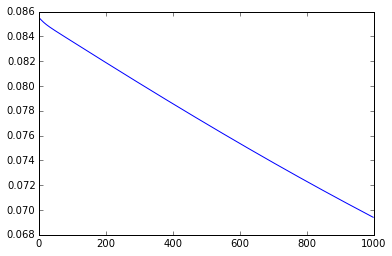

In [56]:
plt.plot(err)